In [1]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import healpy as hp

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.set_loglevel('WARNING')

INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [11]:

url = 'rubin@usdf-prompt-processing-dev.slac.stanford.edu/lsst-devl'
pp_collections = ['u/elhoward/DM-44138/LSSTComCamSim']
namespace = 'elhoward_dm44138_LSSTComCamSim'

In [8]:
#pp_butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)
#pp_apdb = apdb.ApdbPostgresQuery(url=url, namespace=namespace, instrument=instrument)


In [9]:
url = 'cassandra://sdfk8sk001.sdf.slac.stanford.edu:9042/pp_apdb_lsstcomcamsim_or4'
pp_collections = ['LSSTComCamSim/prompt/output-2024-06-27']
# pp_apdb = apdb.ApdbPostgresQuery(url=url,  instrument=instrument)

In [14]:
repo = 'embargo_or4'
instrument = 'LSSTComCamSim'

skymap = 'ops_rehersal_prep_2k_v1'
steps1_and_2a_collections = 'LSSTComCamSim/quickLook/24'
night1_collections = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
night2_collections = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
night3_collections = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
dv_collections = [night1_collections,night2_collections,night3_collections]

dv_butler = dafButler.Butler(repo, collections=dv_collections, instrument=instrument, skymap=skymap)


ERROR:lsst.daf.butler.direct_butler._direct_butler:Failed to instantiate Butler from config s3://embargo@rubin-summit-users/butler.yaml.


OperationalError: (psycopg2.OperationalError) connection to server at "172.24.5.152", port 5432 failed: FATAL:  no such user
connection to server at "172.24.5.152", port 5432 failed: FATAL:  no such user

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [13]:
# assumes we are considering one tract at a time
dvDataIds = [{'tract': 9813, 'patch': 180}, {'tract': 9813, 'patch': 181}]#, {'tract': 9813, 'patch': 182}]
tract = dvDataIds[0]['tract']
patches = str(tuple(set([dataId['patch'] for dataId in dvDataIds])))
where_clause = f"skymap='{skymap}' AND tract={tract} AND patch IN {patches}"
result = list(dv_butler.registry.queryDatasets('goodSeeingDiff_diaSrcTable', collections=dv_collections, where=where_clause))

NameError: name 'dv_butler' is not defined

In [7]:
ppDataIds = []
for item in result:
    visit = item.dataId['visit']
    detector = item.dataId['detector']
    ppDataId = {'visit': visit, 'detector': detector}
    ppDataIds.append(ppDataId)

In [8]:
ppDataIds_unique = list(map(dict, set(tuple(sorted(sub.items())) for sub in ppDataIds)))

In [9]:
print(len(ppDataIds))
print(len(ppDataIds_unique))

2901
916


In [10]:
# verify that the list looks reasonable and we can cut it down to not-super-long
for dataId in ppDataIds_unique[::40]:
    print(dataId)

{'detector': 2, 'visit': 7024040300065}
{'detector': 4, 'visit': 7024040300227}
{'detector': 2, 'visit': 7024040300189}
{'detector': 7, 'visit': 7024040200220}
{'detector': 5, 'visit': 7024040300216}
{'detector': 5, 'visit': 7024040300199}
{'detector': 2, 'visit': 7024040400087}
{'detector': 4, 'visit': 7024040300108}
{'detector': 5, 'visit': 7024040300098}
{'detector': 4, 'visit': 7024040300089}
{'detector': 8, 'visit': 7024040400212}
{'detector': 1, 'visit': 7024040300096}
{'detector': 5, 'visit': 7024040400105}
{'detector': 2, 'visit': 7024040400187}
{'detector': 2, 'visit': 7024040300064}
{'detector': 8, 'visit': 7024040200074}
{'detector': 2, 'visit': 7024040200118}
{'detector': 7, 'visit': 7024040400217}
{'detector': 4, 'visit': 7024040300090}
{'detector': 5, 'visit': 7024040400205}
{'detector': 5, 'visit': 7024040400199}
{'detector': 5, 'visit': 7024040300230}
{'detector': 1, 'visit': 7024040200100}


In [11]:
# takes 2 minutes, 50 sec

pp_lengths = []
dv_lengths = []
for dataId in ppDataIds_unique:
    pp_oneDiaSrcTable = pp_butler.get('goodSeeingDiff_diaSrcTable', dataId=dataId)
    dv_oneDiaSrcTable = dv_butler.get('goodSeeingDiff_diaSrcTable', dataId=dataId)
    pp_lengths.append(len(pp_oneDiaSrcTable))
    dv_lengths.append(len(dv_oneDiaSrcTable))

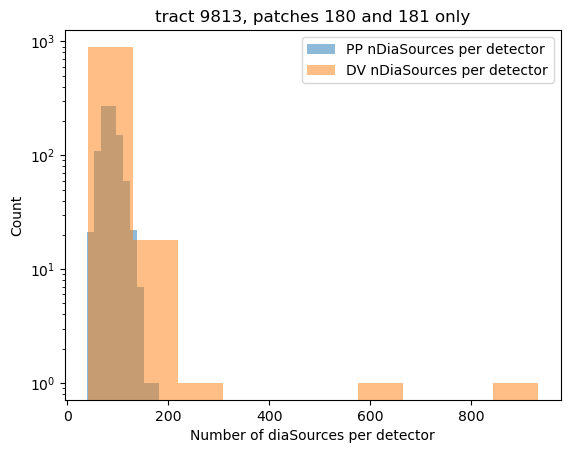

In [12]:
plt.figure()
plt.hist(pp_lengths, label='PP nDiaSources per detector', alpha=0.5, log=True)
plt.hist(dv_lengths, label='DV nDiaSources per detector', alpha=0.5, log=True)
plt.xlabel('Number of diaSources per detector')
plt.ylabel('Count')
plt.title('tract 9813, patches 180 and 181 only')
plt.legend()
plt.show()

In [21]:
schema =  f'elhoward_dm44138_LSSTComCamSim'
apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)
collections = 'u/elhoward/DM-44138/LSSTComCamSim'
registry = pp_butler.registry
# This is to see all of the columns avaliable
with apdbQuery.connection as connection:
    # Query to fetch all column names from the DiaObject table
    query_columns = '''
    SELECT column_name
    FROM information_schema.columns
    WHERE table_schema = 'elhoward_dm44138_LSSTComCamSim' AND table_name = 'DiaSource';
    '''
    df_columns = pd.read_sql_query(query_columns, connection)
    print("Available columns:", df_columns['column_name'].tolist())

Available columns: ['diaSourceId', 'visit', 'detector', 'diaObjectId', 'ssObjectId', 'parentDiaSourceId', 'ssObjectReassocTime', 'midpointMjdTai', 'ra', 'raErr', 'dec', 'decErr', 'ra_dec_Cov', 'x', 'xErr', 'y', 'yErr', 'x_y_Cov', 'centroid_flag', 'apFlux', 'apFluxErr', 'apFlux_flag', 'apFlux_flag_apertureTruncated', 'snr', 'psfFlux', 'psfFluxErr', 'psfRa', 'psfRaErr', 'psfDec', 'psfDecErr', 'psfFlux_psfRa_Cov', 'psfFlux_psfDec_Cov', 'psfRa_psfDec_Cov', 'psfLnL', 'psfChi2', 'psfNdata', 'psfFlux_flag', 'psfFlux_flag_edge', 'psfFlux_flag_noGoodPixels', 'trailFlux', 'trailFluxErr', 'trailRa', 'trailRaErr', 'trailDec', 'trailDecErr', 'trailLength', 'trailLengthErr', 'trailAngle', 'trailAngleErr', 'trailFlux_trailRa_Cov', 'trailFlux_trailDec_Cov', 'trailFlux_trailLength_Cov', 'trailFlux_trailAngle_Cov', 'trailRa_trailDec_Cov', 'trailRa_trailLength_Cov', 'trailRa_trailAngle_Cov', 'trailDec_trailLength_Cov', 'trailDec_trailAngle_Cov', 'trailLength_trailAngle_Cov', 'trailLnL', 'trailChi2', 'tra

In [22]:
# just a small cell showing number of observations in different parts of the sky

## Grouping tracts based on location on the sky
group1 = [3384, 3385]
group2 = [2261, 2262, 2494, 2495]
group3 = [9880, 9881, 9638]
group4 = [3533, 3534, 3345, 3346]
group5 = [7683, 7684, 7445, 7446]
group6 = [9590, 9591, 9347, 9348]
group7 = [9812, 9813]
group8 = [7149, 6914, 6915]

groups = [group1, group2, group3, group4, group5, group6, group7, group8]

def getUniqueVisits(collections, tracts):
    """Get the unique visits from a given tract."""
    visitList = []
    tracts = ','.join(str(tract) for tract in tracts)
    for d in sorted(registry.queryDatasets(datasetType="goodSeeingDiff_diaSrcTable", collections=collections, \
        where=f"skymap='ops_rehersal_prep_2k_v1' AND tract IN ({tracts})")): 
        visitList.append(d.dataId['visit'])
    uniqueVisits = list(set(visitList))
    return uniqueVisits

visitListByGroup = []

for group in groups:
    visits = getUniqueVisits(collections, group)
    visitListByGroup.append(visits)
    print("There are "+str(len(visits))+f" visits in tracts {group}")

There are 119 visits in tracts [3384, 3385]
There are 352 visits in tracts [2261, 2262, 2494, 2495]
There are 298 visits in tracts [9880, 9881, 9638]
There are 295 visits in tracts [3533, 3534, 3345, 3346]
There are 354 visits in tracts [7683, 7684, 7445, 7446]
There are 238 visits in tracts [9590, 9591, 9347, 9348]
There are 356 visits in tracts [9812, 9813]
There are 299 visits in tracts [7149, 6914, 6915]


# Cassandra 

In [15]:
from lsst.analysis.ap import apdbCassandra
or4_apdb = apdbCassandra.DbCassandraQuery(config_uri='s3://embargo@rubin-summit-users/apdb_config/cassandra/pp_apdb_lsstcomcamsim_or4.py')

INFO:cassandra.cluster:New Cassandra host <Host: 172.24.4.176:9042 datacenter1> discovered
INFO:cassandra.cluster:New Cassandra host <Host: 172.24.4.173:9042 datacenter1> discovered
INFO:cassandra.cluster:New Cassandra host <Host: 172.24.4.172:9042 datacenter1> discovered
INFO:cassandra.cluster:New Cassandra host <Host: 172.24.4.175:9042 datacenter1> discovered


In [16]:
or4_obj = or4_apdb.load_objects(limit=1e7)

In [26]:
# We got all of them, less than 1e7 here
len(or4_obj)

1430368

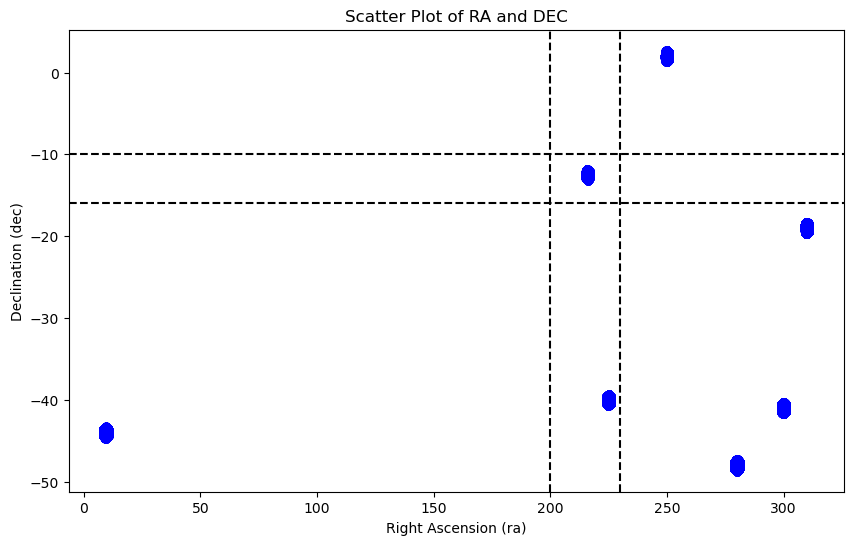

In [31]:
# Extract the columns 'ra' and 'dec'
ra = or4_obj['ra']
dec = or4_obj['dec']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ra, dec, c='blue', alpha=0.5)

# Add labels and title
plt.xlabel('Right Ascension (ra)')
plt.ylabel('Declination (dec)')
plt.title('Scatter Plot of RA and DEC')

plt.axhline(y=-10, color='k', ls = '--')
plt.axhline(y=-16, color='k', ls = '--')
plt.axvline(x=200, color='k', ls = '--')
plt.axvline(x=230, color='k', ls = '--')

# Show the plot
plt.show()

In [39]:
# lets look at only one field
# objects
obj4_field = or4_obj[(or4_obj['ra'] > 200) & (or4_obj['ra'] < 230) & (or4_obj['dec'] > -16) & (or4_obj['dec'] < -10)]
obj4_field

,diaObjectId,lastNonForcedSource,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,pmRaErr,pmDec,pmDecErr,parallax,parallaxErr,pmRa_pmDec_Cov,pmRa_parallax_Cov,pmDec_parallax_Cov
90977,3068394109505896449,2024-06-26 02:12:25,215.940635,1.164427e-05,-12.980294,1.620619e-05,4.259947e-11,60487.089310,None,None,None,None,None,None,None,None,None
90978,3068394109505896450,2024-06-26 02:49:53,215.932781,NaN,-12.977373,NaN,NaN,60487.115497,None,None,None,None,None,None,None,None,None
90979,3068394109505896451,2024-06-26 02:49:53,215.955608,NaN,-12.984331,NaN,NaN,60487.115497,None,None,None,None,None,None,None,None,None
90980,3068394109505896452,2024-06-26 02:32:51,216.003270,9.587428e-07,-12.998648,9.911652e-07,3.736781e-15,60487.103777,None,None,None,None,None,None,None,None,None
90981,3068394109505896453,2024-06-26 02:12:25,215.952055,1.678011e-05,-12.981463,1.948738e-05,2.935007e-11,60487.089310,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1131829,3068394172890218585,2024-06-26 02:55:53,215.677023,2.335178e-05,-12.260069,2.930849e-05,-1.390424e-11,60487.119709,None,None,None,None,None,None,None,None,None
732181,3068394172890218592,2024-06-26 02:55:53,215.558428,NaN,-12.258833,NaN,NaN,60487.119709,None,None,None,None,None,None,None,None,None
1398480,3068394172890218629,2024-06-26 02:55:53,215.749328,NaN,-12.203916,NaN,NaN,60487.119709,None,None,None,None,None,None,None,None,None
480888,3068394172890218631,2024-06-26 02:55:53,215.565520,3.946260e-05,-12.211074,4.004168e-05,-9.789058e-13,60487.119709,None,None,None,None,None,None,None,None,None


# Single object - get sources

In [72]:
# get sources for one object

from typing import TYPE_CHECKING, cast

column_names = or4_apdb._apdb._schema.apdbColumnNames(ApdbTables.DiaSource)

query = or4_apdb._build_query(
    ApdbTables.DiaSource,
    columns=column_names,
    where='"diaObjectId" = ?',
    limit=int(100),
)
statement = or4_apdb._apdb._preparer.prepare(query)
result = or4_apdb._apdb._session.execute(
    statement,
    (3068394109505896449,),
    timeout=20,
    execution_profile="read_pandas",
)
catalog = cast(pd.DataFrame, result._current_rows)
# catalog.sort_values(by=["visit", "detector", "diaSourceId"], inplace=True)

In [74]:
catalog

,diaSourceId,visit,detector,diaObjectId,ssObjectId,parentDiaSourceId,ssObjectReassocTime,midpointMjdTai,ra,raErr,...,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter
0,3068394109505896449,7024062500190,0,3068394109505896449,0,0,None,60487.08931,215.940635,0.000012,...,False,False,False,False,False,False,False,False,False,False


In [50]:
catalog

,diaSourceId,visit,detector,diaObjectId,ssObjectId,parentDiaSourceId,ssObjectReassocTime,midpointMjdTai,ra,raErr,...,pixelFlags_saturated,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter
0,3068394109514285250,7024062500190,2,3068394109514285250,0,0,None,60487.089310,215.475699,7.951079e-06,...,False,False,False,False,False,False,False,False,False,False
1,3068394109514285251,7024062500190,2,3068394109514285251,0,0,None,60487.089310,215.460346,NaN,...,False,False,False,False,False,False,False,False,False,False
2,3068394109514285252,7024062500190,2,3068394109514285252,0,0,None,60487.089310,215.463500,6.361637e-07,...,False,False,False,False,False,False,False,False,False,False
3,3068394109514285257,7024062500190,2,3068394109514285257,0,0,None,60487.089310,215.470215,NaN,...,False,False,False,False,False,False,False,False,False,False
4,3068394109514285260,7024062500190,2,3068394109514285260,0,0,None,60487.089310,215.453495,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75813,3068394140644409501,7024062500219,0,3068394130980733163,0,0,None,60487.104245,216.144726,1.014280e-05,...,False,False,False,False,False,False,False,False,False,False
75814,3068394140644409505,7024062500219,0,3068394130980733161,0,0,None,60487.104245,216.129697,6.862383e-06,...,False,False,False,False,False,False,False,False,False,False
75815,3068394140644409517,7024062500219,0,3068394130980733167,0,0,None,60487.104245,216.145364,1.325396e-05,...,False,False,False,False,False,False,False,False,False,False
75816,3068394140644409527,7024062500219,0,3068394133128216595,0,0,None,60487.104245,216.162124,NaN,...,False,False,False,False,False,False,False,False,False,False


In [55]:
# Get unique diaObjectId values and their counts
unique_ids, counts = np.unique(catalog['diaObjectId'], return_counts=True)

# Find the index of the maximum count
max_count_index = np.argmax(counts)

# Get the diaObjectId with the maximum count
diaObjectId_with_max_count = unique_ids[max_count_index]

# Display the result
print(f'The diaObjectId with the most counts is: {diaObjectId_with_max_count} with {counts[max_count_index]} counts')

The diaObjectId with the most counts is: 3068394109518479520 with 49 counts


In [56]:
query = or4_apdb._build_query(
    ApdbTables.DiaSource,
    columns=column_names,
    where='"diaObjectId" = ?',
    limit=int(100),
)
statement = or4_apdb._apdb._preparer.prepare(query)
result = or4_apdb._apdb._session.execute(
    statement,
    (3068394109518479520,),
    timeout=20,
    execution_profile="read_pandas",
)
catalog_single = cast(pd.DataFrame, result._current_rows)

In [62]:
list(catalog_single.columns)

['diaSourceId',
 'visit',
 'detector',
 'diaObjectId',
 'ssObjectId',
 'parentDiaSourceId',
 'ssObjectReassocTime',
 'midpointMjdTai',
 'ra',
 'raErr',
 'dec',
 'decErr',
 'ra_dec_Cov',
 'x',
 'xErr',
 'y',
 'yErr',
 'x_y_Cov',
 'centroid_flag',
 'apFlux',
 'apFluxErr',
 'apFlux_flag',
 'apFlux_flag_apertureTruncated',
 'snr',
 'psfFlux',
 'psfFluxErr',
 'psfRa',
 'psfRaErr',
 'psfDec',
 'psfDecErr',
 'psfFlux_psfRa_Cov',
 'psfFlux_psfDec_Cov',
 'psfRa_psfDec_Cov',
 'psfLnL',
 'psfChi2',
 'psfNdata',
 'psfFlux_flag',
 'psfFlux_flag_edge',
 'psfFlux_flag_noGoodPixels',
 'trailFlux',
 'trailFluxErr',
 'trailRa',
 'trailRaErr',
 'trailDec',
 'trailDecErr',
 'trailLength',
 'trailLengthErr',
 'trailAngle',
 'trailAngleErr',
 'trailFlux_trailRa_Cov',
 'trailFlux_trailDec_Cov',
 'trailFlux_trailLength_Cov',
 'trailFlux_trailAngle_Cov',
 'trailRa_trailDec_Cov',
 'trailRa_trailLength_Cov',
 'trailRa_trailAngle_Cov',
 'trailDec_trailLength_Cov',
 'trailDec_trailAngle_Cov',
 'trailLength_trailAn

In [68]:
import astropy.units as u
def create_mag_errors(sciFlux, sciFluxErr):
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    return mag, magErr

s1_obj_g = catalog_single[catalog_single['band']=='g']
s1_obj_r = catalog_single[catalog_single['band']=='r']
s1_obj_i = catalog_single[catalog_single['band']=='i']

s1_mag_g, s1_mag_err_g = create_mag_errors(s1_obj_g['scienceFlux'].values, s1_obj_g['scienceFluxErr'].values)
s1_mag_r, s1_mag_err_r = create_mag_errors(s1_obj_r['scienceFlux'].values, s1_obj_r['scienceFluxErr'].values)
s1_mag_i, s1_mag_err_i = create_mag_errors(s1_obj_i['scienceFlux'].values, s1_obj_i['scienceFluxErr'].values)

min_time = np.min(catalog_single['midpointMjdTai'])

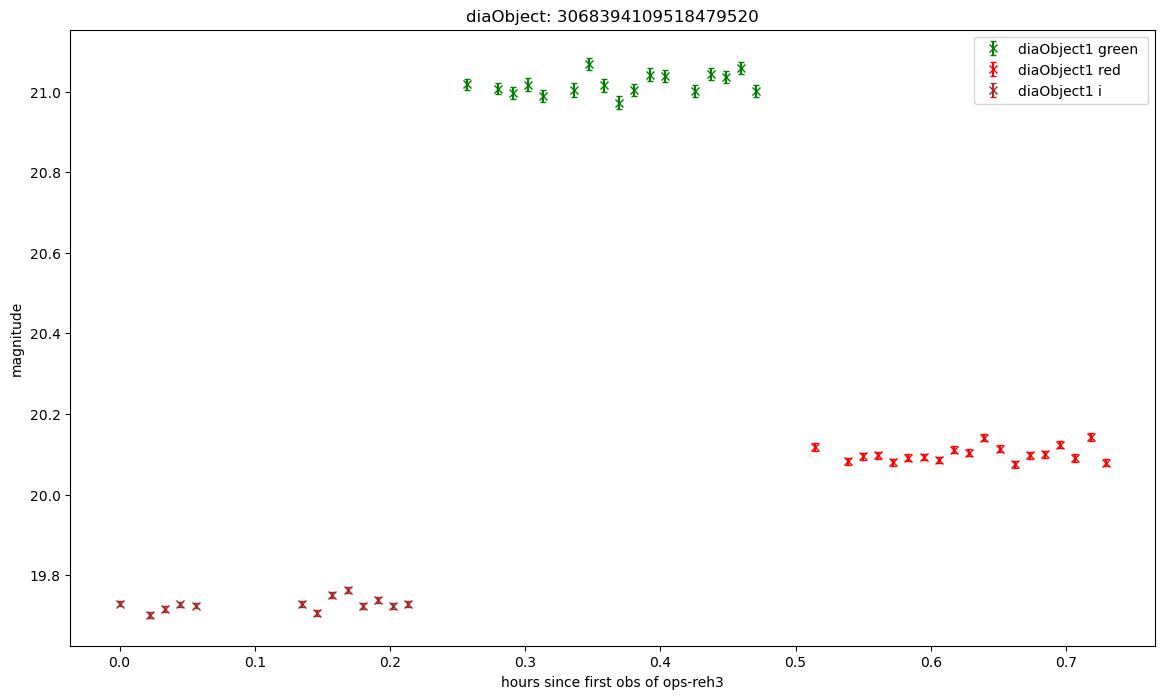

In [71]:
plt.figure(figsize=(14,8))
plt.errorbar((s1_obj_g['midpointMjdTai'].values - min_time)*24,s1_mag_g, s1_mag_err_g, marker = 'x', capsize=2, ls='none', color = 'green', label = 'diaObject1 green ')

plt.errorbar((s1_obj_r['midpointMjdTai'].values - min_time)*24,s1_mag_r, s1_mag_err_r, marker = 'x', capsize=2, ls='none', color = 'red', label = 'diaObject1 red ')

plt.errorbar((s1_obj_i['midpointMjdTai'].values - min_time)*24,s1_mag_i, s1_mag_err_i, marker = 'x', capsize=2, ls='none', color = 'brown', label = 'diaObject1 i ')

# plt.plot((mjd-min_time)*24, magnorm_r, color ='red', ls ='--', label = 'input r-band')
# plt.plot((mjd-min_time)*24, magnorm_i, color ='brown', ls ='--', label = 'input i-band')
# plt.plot((mjd-min_time)*24, magnorm_g, color ='green', ls ='--', label = 'input g-band')

plt.xlim()
plt.xlabel('hours since first obs of ops-reh3')
plt.ylabel('magnitude')

plt.title('diaObject: '+str(catalog_single['diaObjectId'].loc[0]))
plt.legend()

# Many objects - sources

In [89]:
# 

# Get column names for the DiaSource table
column_names = or4_apdb._apdb._schema.apdbColumnNames(ApdbTables.DiaSource)

# Build the query for the specified ra and dec range
query = or4_apdb._build_query(
    ApdbTables.DiaSource,
    columns=column_names,
    where='ra >= 200 AND ra <= 230 AND dec >= -16 AND dec <= -10',
    limit=100000  # Adjust the limit as needed, or remove for no limit
)

# Prepare and execute the query
statement = or4_apdb._apdb._preparer.prepare(query)
result = or4_apdb._apdb._session.execute(
    statement,
    timeout=200,
    execution_profile="read_pandas"
)

# Convert the result to a pandas DataFrame
src4_field = cast(pd.DataFrame, result._current_rows)

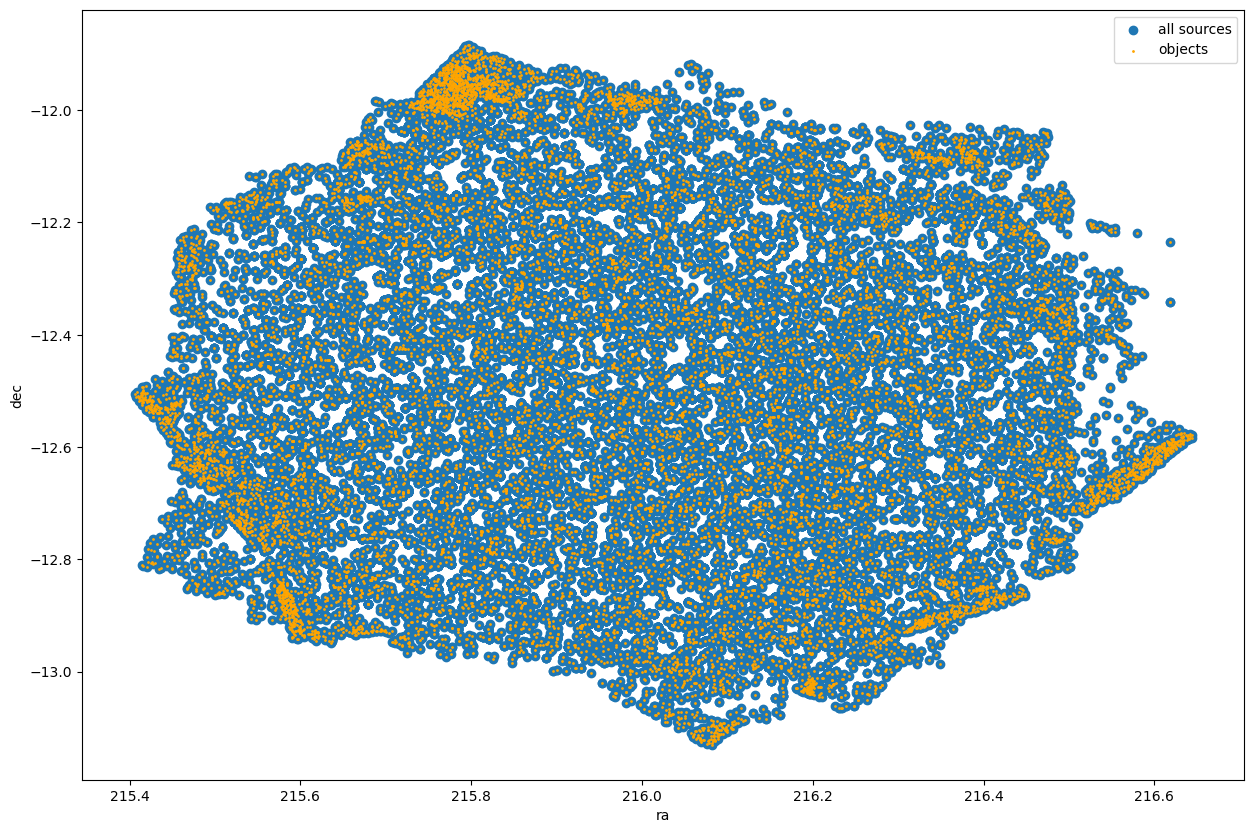

In [90]:
plt.figure(figsize=(15,10))

plt.scatter(src4_field['ra'],src4_field['dec'], label = 'sources')
plt.scatter(obj4_field['ra'],obj4_field['dec'], s=1, color = 'orange', label = 'objects')
plt.xlabel('ra')
plt.ylabel('dec')
plt.legend(['all sources', 'objects'])

In [3]:
import numpy as np
-2.5*np.log10(0.006195)+8.9

14.419896723219795